In [37]:
import pandas as pd
import seaborn as sns
from pre_processing import remove_empty, remove_HTML, remove_new_line
import torch
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, XLNetTokenizer, XLNetModel, AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
import random

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='mps')

## Load data

In [38]:
taxonomy = pd.read_json('data/taxonomy_headings.json')
taxonomy = taxonomy.drop(['created_at',	'updated_at',	'deleted_at', 'alias_of_id', 'short_description',	'original_id'], axis=1)

taxonomy.head(10)

,id,name,description,translations
0,1,Root,Root,"{""name"":{""en"":""Root"",""fr"":null},""description"":..."
1,2,All Mental Health Resources,<p>\r\n\tThe listings of mental health resourc...,"{""name"":{""en"":""All Mental Health Resources"",""f..."
2,3,Crisis and Emergency,<p>\r\n\tRefers to all programs that provide i...,"{""name"":{""en"":""Crisis and Emergency"",""fr"":""Res..."
3,4,"System Navigation, including Information and R...","<p>\r\n\tAre you looking for help, but don&#39...","{""name"":{""en"":""System Navigation, including In..."
4,5,Child Welfare including Children's Aid Society...,<p>The child welfare / child protection system...,"{""name"":{""en"":""Child Welfare including Childre..."
5,6,Emergency Shelter and Housing,<p>\r\n\tThere are various shelters that peopl...,"{""name"":{""en"":""Emergency Shelter and Housing"",..."
6,7,Hospital Emergency Department,<p>\r\n\tIs there an emergency such as medical...,"{""name"":{""en"":""Hospital Emergency Department"",..."
7,8,"Crisis Lines including Telephone, Online and Chat",<p>\r\n\tAre you in a crisis? Crisis lines off...,"{""name"":{""en"":""Crisis Lines including Telephon..."
8,9,Psychiatrists,<p>\r\n\tPsychiatrists are medical doctors who...,"{""name"":{""en"":""Psychiatrists"",""fr"":""Psychiatre..."
9,10,A-Z Mental Health Conditions and Topics,<p>\r\n\tAlphabetical list of mental health to...,"{""name"":{""en"":""A-Z Mental Health Conditions an..."


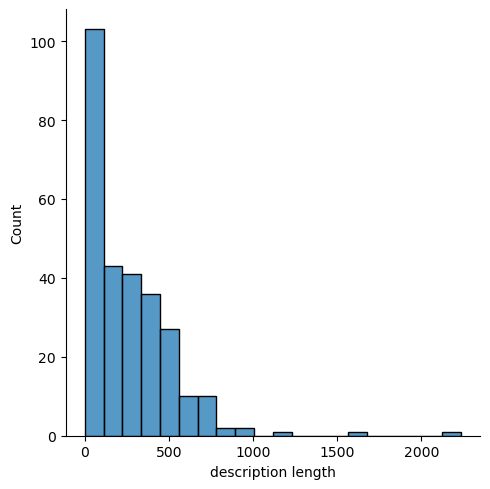

In [39]:
taxonomy['description length'] = taxonomy['description'].apply(len)
sns.displot(taxonomy, x='description length')
infoSheet = taxonomy.drop(['description length'], axis=1)

In [40]:
infoSheet = pd.read_csv("data/infoSheets_2023-05-18.csv")
print(infoSheet.isnull().sum())
# infoSheet = infoSheet.dropna(subset=['abstract_en'])
# infoSheet.reset_index(drop=True, inplace=True)
print('\nNumber of rows: ', len(infoSheet.index))
infoSheet.head(5)

ID                        0
name_en                   0
name_fr                 138
abstract_en              20
abstract_fr             146
description_en            0
description_fr          140
taxonomy heading ids      0
dtype: int64

Number of rows:  346


,ID,name_en,name_fr,abstract_en,abstract_fr,description_en,description_fr,taxonomy heading ids
0,84606,ADHD Medication Side Effects: Low Appetite and...,NaN,Stimulants prescribed for ADHD can lead to red...,NaN,Background\r\nStimulant medications for attent...,NaN,0
1,92619,5-HTP (5-hydroxytryptophan),NaN,5-HTP (5-Hydroxytryptophan) is a natural subst...,NaN,What is 5-HTP?\r\n5-HTP (5-Hydroxytryptophan) ...,NaN,0
2,50150,A Simple Way to Swallow Pills: The Head Postur...,Truc simple pour avaler les pilules: La techni...,"Swallowing pills can hard for many children, y...","Il n’est pas seul! Beaucoup d’enfants, de jeun...",\r\n\t\r\n\t\tDoes your child or teen have pro...,\r\n\t\r\n\t\tVotre enfant a-t-il de la diffic...,0
3,8920,Abuse and Domestic Violence,Maltraitance et violence familiale,"Abuse is behaviour used to intimidate, isolate...",La maltraitance est un comportement visant à i...,\r\n\tWhat is Abuse and Domestic Violence?\r\n...,\r\n\tQu&#39;est-ce que la maltraitance et la ...,"0,219,58,8,7,6,50,9,36,54,37"
4,69660,"ADHD in Children, Youth and Adults: Informatio...",NaN,Attention deficit hyperactivity disorder (ADHD...,NaN,"\r\n\tAbbreviations\r\n\r\n\tADHD, attention-d...",NaN,"0,13"


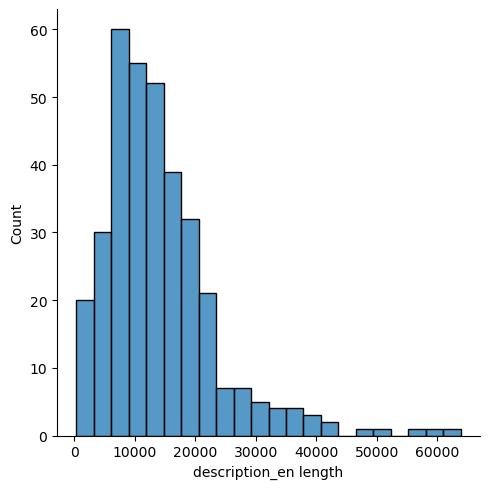

In [41]:
infoSheet['description_en length'] = infoSheet['description_en'].apply(len)
sns.displot(infoSheet, x='description_en length')
infoSheet = infoSheet.drop(['description_en length'], axis=1)

## Pre-processing

In [42]:
infoSheet['description_en'] = infoSheet['description_en'].apply(lambda x: remove_HTML(x))
infoSheet['description_en'] = infoSheet['description_en'].apply(lambda x: remove_new_line(x))

In [43]:
print('Length of taxonomy before preprocessing:', len(taxonomy.index))
taxonomy['description'] = taxonomy['description'].apply(lambda x: remove_HTML(x))
taxonomy['description'] = taxonomy['description'].apply(lambda x: remove_new_line(x))
taxonomy = remove_empty('description', taxonomy)
print('Length of taxonomy after preprocessing:', len(taxonomy.index))

Length of taxonomy before preprocessing: 277
Length of taxonomy after preprocessing: 192


## Randomly chose 10 taxonomy headings as search terms

In [44]:
# Generate ten random integers between 0 and 191
random_ids = [random.randint(0, len(taxonomy.index)) for i in range(10)]
search_terms = []
for each in random_ids:
    print(str(each) + ': ' + taxonomy.iloc[each]['name'] + '\n' + taxonomy.iloc[each]['description'] + '\n')
    search_terms.append(taxonomy.iloc[each]['description'])

64: Drama Therapy
Drama therapy (or the related term psychodrama) is a way of helping others by using drama or theater processes, and is given by an accredited drama therapist. Drama gives participants an opportunity to tell their stories, set goals, solve problems, express feelings, resulting in behaviour change, skill-building and emotional growth.

63: Solution-Focused Therapy (SFT)
Solution-focused therapy (SFT) focuses on empowering individuals to find solutions in their life by figuring out what a persons goals are, and supporting them to find ways to achieve those goals. Various types of professionals may have training in SFT, and may work in counselling agencies, or in private practice.

34: Mental Health Professionals
This section has information on how to find different types of (mental) health professionals.

165: Professionals
This category is for resources that are directed primarily towards professionals (such as health care professionals, researchers, educators, policy m

## Helper functions

In [45]:
def get_highest_numbers_with_indices(numbers, n=10):
    """
    Returns the n highest numbers in a list along with their indices.
    :param numbers: List of numbers
    :param n: Number of highest numbers to retrieve (default: 10)
    :return: List of tuples containing the highest numbers and their indices
    """
    highest_numbers_with_indices = []
    for i, num in enumerate(numbers):
        if len(highest_numbers_with_indices) < n:
            highest_numbers_with_indices.append((num, i))
            highest_numbers_with_indices.sort(reverse=True)
        else:
            if num > highest_numbers_with_indices[-1][0]:
                highest_numbers_with_indices.pop()
                highest_numbers_with_indices.append((num, i))
                highest_numbers_with_indices.sort(reverse=True)
    return highest_numbers_with_indices

## BERT

In [46]:
tokenizer = BertTokenizer.from_pretrained("AIMH/mental-bert-large-uncased")
model = BertModel.from_pretrained("AIMH/mental-bert-large-uncased").to(device)
model.eval()

Some weights of the model checkpoint at AIMH/mental-bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

### Generate embeddings for search terms

In [47]:
tokenized_search_terms = tokenizer(search_terms, padding='max_length', max_length=512, return_tensors='pt').to(device)

# Generate embeddings
search_term_embeddings = []
with torch.no_grad():
    embedding = model(input_ids=tokenized_search_terms['input_ids'],
                    attention_mask=tokenized_search_terms['attention_mask'],
                    token_type_ids=tokenized_search_terms['token_type_ids'])
    embedding = embedding.last_hidden_state.mean(dim=1).cpu()
    
search_term_embeddings = embedding.tolist()

### Load embeddings from file

In [48]:
infoSheet_embeddings = torch.load('data/embeddings/bert_infoSheet_embeddings.pt')
print(infoSheet_embeddings.shape)

torch.Size([326, 1024])


### Prediction

In [49]:
predictions = {'infoSheet_record': [], 'Similarity score': []}

for idx in range(len(search_term_embeddings)):
    # Records
    cos_sim = []
    for each in infoSheet_embeddings:
        cos_sim.append(1 - cosine(search_term_embeddings[idx], each))

    lst = get_highest_numbers_with_indices(cos_sim)

    for id in lst:
        # (taxonomy_id, infoSheet_id)
        predictions['infoSheet_record'].append((random_ids[idx], id[1]))
        predictions['Similarity score'].append(id[0])

predictions = pd.DataFrame(predictions)
predictions.head(10)

,infoSheet_record,Similarity score
0,"(64, 283)",0.895325
1,"(64, 188)",0.893200
2,"(64, 249)",0.893038
3,"(64, 97)",0.892711
4,"(64, 98)",0.891644
5,"(64, 55)",0.883894
6,"(64, 52)",0.881903
7,"(64, 300)",0.880745
8,"(64, 101)",0.878496
9,"(64, 238)",0.876751


## Evaluation

In [52]:
infoSheet.loc[infoSheet.index == 64]

,ID,name_en,name_fr,abstract_en,abstract_fr,description_en,description_fr,taxonomy heading ids
64,82593,Capacity and Consent As Your Child/Youth with ...,NaN,All parents want to ensure their children and ...,NaN,Case 1 Dave is a 17-year-old with autism spect...,NaN,"0,45,215"


In [57]:
taxonomy.loc[taxonomy.index == 215]

,id,name,description,translations,description length


In [31]:
retrieved_relevant = 0

for (pred_taxonomy_id, pred_infoSheet_id) in predictions['infoSheet_record'].to_list():
    # get row from infoSheet using pred_infoSheet_id
    taxonomy_ids = infoSheet.loc[infoSheet.index == pred_infoSheet_id]['taxonomy heading ids'].to_list()[0].split(',')
    print(pred_taxonomy_id)
    print(taxonomy_ids)
    if pred_taxonomy_id in taxonomy_ids:
        retrieved_relevant += 1

print(retrieved_relevant)
print('Precision: ' + str(retrieved_relevant / len(predictions.index)))

113
['0', '13']
113
['0']
113
['0', '15', '110', '50', '9', '36']
113
['0', '59', '43', '177', '267']
113
['0', '59', '8', '7', '71']
113
['0']
113
['0', '117']
113
['0', '208']
113
['0', '16']
113
['0', '226']
141
['0', '59', '35', '52']
141
['0', '198']
141
['0']
141
['0', '13']
141
['0']
141
['0']
141
['0', '79', '50', '9', '36']
141
['0', '59', '8', '7', '71']
141
['0', '117']
141
['0', '235']
179
['0', '53']
179
['0', '53']
179
['0', '13']
179
['0']
179
['0', '221', '77', '63', '50', '9', '36', '40']
179
['0', '59', '54', '50', '9', '36', '37', '207']
179
['0', '59', '54', '9', '36', '75', '31']
179
['0', '45']
179
['0']
179
['0', '75', '63', '36']
45
['0', '13']
45
['0']
45
['0']
45
['0', '48', '50', '9', '36']
45
['0', '13', '241', '229', '9', '36']
45
['0', '217']
45
['0']
45
['0', '24', '54', '49', '9', '36', '37']
45
['0', '64']
45
['0', '15']
179
['0', '53']
179
['0', '53']
179
['0', '13']
179
['0']
179
['0', '221', '77', '63', '50', '9', '36', '40']
179
['0', '59', '54', '5